In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel

from SGDRegressor import SGDRegressor


%matplotlib inline

In [86]:

def load_data(path):
	return pd.read_csv(path, header=None)

data = load_data('year-prediction-msd-train.txt')

data  = np.asarray(data[0:111452])

Y = data[:,0]
X = data[:,1:]

In [98]:
def normalize(X):
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    return Xc

def scale(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

def pca(X, n):
    pca = PCA(n_components=n)
    return pca.fit_transform(X)

def mir(X, Y):
    mi = mutual_info_regression(X, Y)
    mi_sort = sorted(mi, reverse=True)
    mi_index_sort = np.argsort(mi)[::-1]
    mi = np.asarray(mi_sort)
    
    return mi

def index_to_remove(mi, treshold):
    return np.where(mi < treshold)[0]
    

def remove_features(X, features):
    return np.delete(X, features, axis=1)


def cross_validation(X_c, Y_c, max_iter=50, batch_size=20, n_splits=5, learning_rate=0.001):
    cv = KFold(n_splits=n_splits)
    scores = list()
    best_model = None
    less_error = 100000000000000000000000
    for train, test in cv.split(X_c, Y_c):
        
        sgd = SGDRegressor(learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)
        
        sgd.fit(X_c[train], Y_c[train])
        
        y_pred = sgd.predict(X_c[test])
        
        error = np.sqrt(mean_squared_error(Y_c[test], y_pred))
        
        scores.append(error)
        print("error", error)
        if error < less_error:
            less_error = error
            best_model = sgd
        
    return scores


def tree(X, Y):
    clf = ExtraTreesClassifier()
    clf = clf.fit(X, Y)
    importances = clf.feature_importances_

    model = SelectFromModel(clf, prefit=True)
    return model.transform(X),importances, clf

def plot_importances(X,importances, indices, visible):

    assert X.shape[1] == len(indices)
    # Plot the feature importances of the forest
    fig = plt.figure(figsize=(20,12))

    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.ylabel('Feature Importance')
    plt.xlabel('Feature Index')
    
    
    if (not visible):
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') # labels along the bottom edge are off
    plt.show()

In [88]:
X_scaled = scale(X)
X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0)

X_pca = pca(X, 0.95)

In [89]:
X_tree, importances, forest = tree(X_scaled, Y)

In [90]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [91]:
#Normal Equation
def normal_equation(X, Y, X_test, Y_test):
    regression = linear_model.LinearRegression()

    regression.fit(X, Y)

    y_pred = regression.predict(X_test)

    print("R@: %.2f "%r2_score(Y_test, y_pred))
    print("MSE %.2f "%mean_squared_error(Y_test, y_pred))
    print("RMSE %.2f "%np.sqrt(mean_squared_error(Y_test, y_pred)))
    

In [92]:
new_indices = indices[0:X_tree.shape[1]]

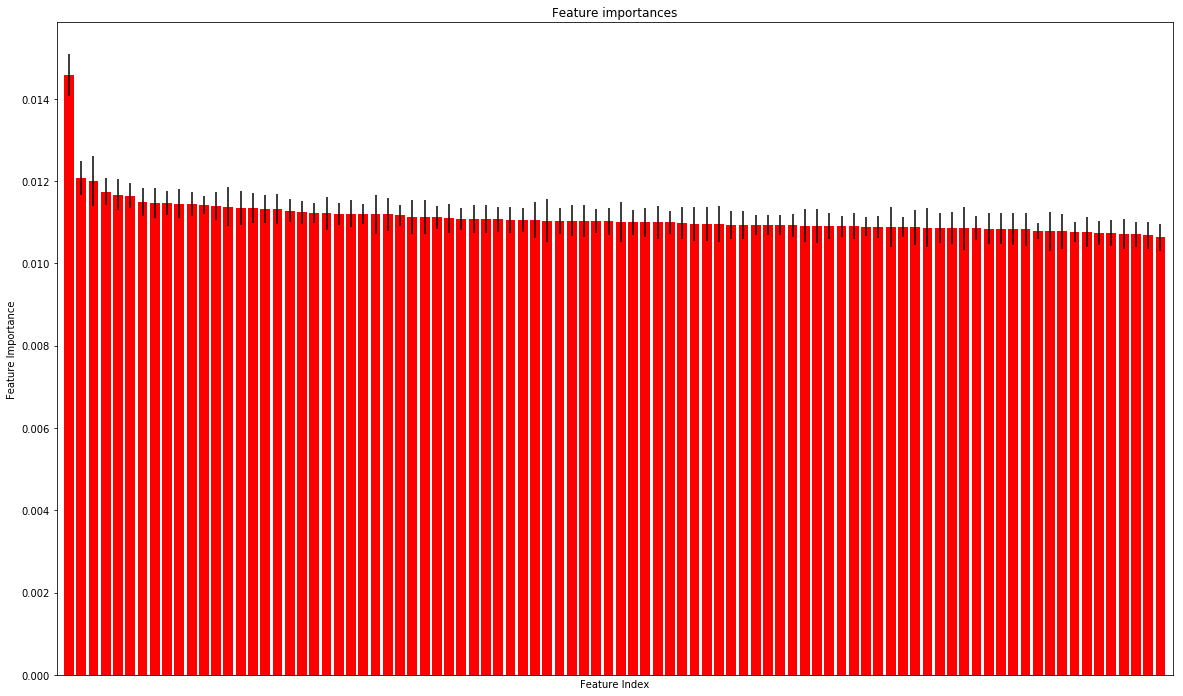

In [97]:
plot_importances(X,importances, indices,visible = False)

In [19]:
#SGD
def SGD(X, Y, X_test, Y_test):
    sgd = SGDRegressor(learning_rate=0.001, max_iter=200, batch_size=20)
    
    sgd.fit(X, Y)
    y_pred = sgd.predict(X_test)

    plt.plot(range(0, len(train_errors)), np.log10(train_errors))
    plt.xlabel('Epochas')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')

    plt.tight_layout()
    plt.show()
    
    print("R@: %.2f "%r2_score(Y_test, y_pred))
    print("MSE %.2f "% mean_squared_error(Y_test, y_pred))
    print("RMSE %.2f "% np.sqrt(mean_squared_error(Y_test, y_pred)))
    

In [34]:
def SGD_cross_validation(X, Y, max_iter=100, batch_size=20, n_splits=5, learning_rate=0.0001):
    scores, best_model = cross_validation(X, Y, max_iter=max_iter, batch_size=batch_size, n_splits=n_splits, learning_rate=learning_rate)
    print("Error ", np.asarray(scores).mean())
    return best_model

In [35]:
def polymonial_regression(X, Y):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)

    X_test_poly =  poly_features.fit_transform(X_test)
    
    sgd = SGDRegressor(learning_rate=0.001, max_iter=100, batch_size=20)
    sgd.fit(X_train_poly, Y_train)

    y_pred = sgd.predict(X_test_poly)
    
    print("R@: %.2f "%r2_score(Y_test, y_pred))
    print("MSE %.2f "% mean_squared_error(Y_test, y_pred))
    print("RMSE %.2f "% np.sqrt(mean_squared_error(Y_test, y_pred)))

In [32]:
#Baseline
SGD(X_train_scaled, Y_train, X_test_scaled, Y_test)

epocha 0
epocha 1
epocha 2
epocha 3


KeyboardInterrupt: 

In [37]:
#Cross validation
SGD_cross_validation(X_scaled, Y)

epocha 0
epocha 1
epocha 2
epocha 3
epocha 4
epocha 5
epocha 6
epocha 7
epocha 8
epocha 9
epocha 10
epocha 11
epocha 12
epocha 13
epocha 14
epocha 15
epocha 16
epocha 17
epocha 18


KeyboardInterrupt: 

In [82]:
#Normal equation with selection
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(X_tree, Y, test_size=0.2, random_state=0)
normal_equation(X_train_n, Y_train_n, X_test_n, Y_test_n)



R@: 0.19 
MSE 94.70 
RMSE 9.73 
epocha 0
epocha 1
epocha 2
epocha 3
epocha 4
epocha 5
epocha 6
epocha 7
epocha 8
epocha 9
epocha 10
epocha 11
epocha 12
epocha 13
epocha 14
epocha 15
epocha 16
epocha 17
epocha 18
epocha 19
epocha 20
epocha 21
epocha 22
epocha 23
epocha 24
epocha 25
epocha 26
epocha 27
epocha 28
epocha 29
epocha 30
epocha 31
epocha 32
epocha 33
epocha 34
epocha 35
epocha 36
epocha 37
epocha 38
epocha 39
epocha 40
epocha 41
epocha 42
epocha 43
epocha 44
epocha 45
epocha 46
epocha 47
epocha 48
epocha 49
epocha 50
epocha 51
epocha 52
epocha 53
epocha 54
epocha 55
epocha 56
epocha 57
epocha 58
epocha 59
epocha 60
epocha 61
epocha 62
epocha 63
epocha 64
epocha 65
epocha 66
epocha 67
epocha 68
epocha 69
epocha 70
epocha 71
epocha 72
epocha 73
epocha 74
epocha 75
epocha 76
epocha 77
epocha 78
epocha 79
epocha 80
epocha 81
epocha 82
epocha 83
epocha 84
epocha 85
epocha 86
epocha 87
epocha 88
epocha 89
epocha 90
epocha 91
epocha 92
epocha 93
epocha 94
epocha 95
epocha 96
epocha 9

In [48]:
#Normal equation
normal_equation(X_train_scaled, Y_train, X_test_scaled, Y_test)

R@: 0.23 
MSE 90.77 
RMSE 9.53 


In [ ]:
#SGD with feature selection
SGD(X_train_n, Y_train_n, X_test_n, Y_test_n)

In [38]:
#Polynomial regression wiht PCA
x_pca_poly = pca(X_scaled, 0.95)
print(x_pca_poly.shape)
polymonial_regression(x_pca_poly, Y)

#Polynomial regression with Tree
polymonial_regression(X_tree, Y)

(111452, 67)
epocha 0
epocha 1
epocha 2
epocha 3
epocha 4
epocha 5
epocha 6
epocha 7
epocha 8
epocha 9
epocha 10
epocha 11
epocha 12
epocha 13
epocha 14
epocha 15
epocha 16
epocha 17
epocha 18
epocha 19
epocha 20
epocha 21
epocha 22
epocha 23
epocha 24
epocha 25
epocha 26
epocha 27
epocha 28
epocha 29
epocha 30
epocha 31
epocha 32
epocha 33
epocha 34
epocha 35
epocha 36
epocha 37
epocha 38
epocha 39
epocha 40
epocha 41
epocha 42
epocha 43
epocha 44
epocha 45
epocha 46
epocha 47
epocha 48
epocha 49
epocha 50
epocha 51
epocha 52
epocha 53
epocha 54
epocha 55
epocha 56
epocha 57
epocha 58
epocha 59
epocha 60
epocha 61
epocha 62
epocha 63
epocha 64
epocha 65
epocha 66
epocha 67
epocha 68
epocha 69
epocha 70
epocha 71
epocha 72
epocha 73
epocha 74
epocha 75
epocha 76
epocha 77
epocha 78
epocha 79
epocha 80
epocha 81
epocha 82
epocha 83
epocha 84
epocha 85
epocha 86
epocha 87
epocha 88
epocha 89
epocha 90
epocha 91
epocha 92
epocha 93
epocha 94
epocha 95
epocha 96
epocha 97
epocha 98
epocha 

In [84]:
#Cross validation with PCA
best_model = SGD_cross_validation(X, Y, max_iter=40, batch_size=20)

epocha 0
epocha 1
epocha 2
epocha 3
epocha 4
epocha 5
epocha 6
epocha 7
epocha 8
epocha 9
epocha 10
epocha 11
epocha 12
epocha 13
epocha 14
epocha 15
epocha 16
epocha 17
epocha 18
epocha 19
epocha 20
epocha 21
epocha 22
epocha 23
epocha 24
epocha 25
epocha 26
epocha 27
epocha 28
epocha 29
epocha 30
epocha 31
epocha 32
epocha 33
epocha 34
epocha 35
epocha 36
epocha 37
epocha 38
epocha 39
error 4.1938853567e+16
epocha 0
epocha 1
epocha 2
epocha 3
epocha 4
epocha 5
epocha 6
epocha 7
epocha 8
epocha 9
epocha 10
epocha 11
epocha 12
epocha 13
epocha 14
epocha 15
epocha 16
epocha 17
epocha 18
epocha 19
epocha 20
epocha 21
epocha 22
epocha 23
epocha 24
epocha 25
epocha 26
epocha 27
epocha 28
epocha 29
epocha 30
epocha 31
epocha 32
epocha 33
epocha 34
epocha 35
epocha 36
epocha 37
epocha 38
epocha 39
error 4.18456266273e+16
epocha 0
epocha 1
epocha 2
epocha 3
epocha 4
epocha 5
epocha 6
epocha 7
epocha 8
epocha 9
epocha 10
epocha 11
epocha 12
epocha 13
epocha 14
epocha 15
epocha 16
epocha 17
epo

ValueError: too many values to unpack (expected 2)

In [55]:
#Test !!!!!! Only one time !!!!!!!
data_test = load_data('year-prediction-msd-test.txt')

In [58]:
data_test  = np.asarray(data_test)

In [80]:
Y_test_real = data_test[:,0]
X_test_real = data_test[:,1:]

X_real_scaled = scale(X_test_real)

In [81]:
Y_real_pred = best_model.predict(X_real_scaled)

In [82]:
print("R@: %.2f "%r2_score(Y_test_real, Y_real_pred))
print("MSE %.2f "% mean_squared_error(Y_test_real, Y_real_pred))
print("RMSE %.2f "% np.sqrt(mean_squared_error(Y_test_real, Y_real_pred)))

R@: -17162140360521171395936256.00 
MSE 2033817043235244068267098112.00 
RMSE 45097860739011.16 
